In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/human-stress-prediction/Stress.csv


**Import Libraries**

In [2]:
import os
import sys
import warnings
import pandas
import numpy
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
warnings.filterwarnings("ignore")
%matplotlib inline

**Load Dataset**

In [3]:
df = pd.read_csv("/kaggle/input/human-stress-prediction/Stress.csv")

In [4]:
df.head()

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005


In [5]:
df.tail()

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
2833,relationships,7oee1t,"[35, 40]","* Her, a week ago: Precious, how are you? (I i...",0,1.000000,1515187044
2834,ptsd,9p4ung,"[20, 25]",I don't have the ability to cope with it anymo...,1,1.000000,1539827412
2835,anxiety,9nam6l,"(5, 10)",In case this is the first time you're reading ...,0,1.000000,1539269312
2836,almosthomeless,5y53ya,"[5, 10]",Do you find this normal? They have a good rela...,0,0.571429,1488938143
2837,ptsd,5y25cl,"[0, 5]",I was talking to my mom this morning and she s...,1,0.571429,1488909516


In [6]:
df.shape

(2838, 7)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subreddit         2838 non-null   object 
 1   post_id           2838 non-null   object 
 2   sentence_range    2838 non-null   object 
 3   text              2838 non-null   object 
 4   label             2838 non-null   int64  
 5   confidence        2838 non-null   float64
 6   social_timestamp  2838 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 155.3+ KB


In [8]:
df.isnull().sum()

subreddit           0
post_id             0
sentence_range      0
text                0
label               0
confidence          0
social_timestamp    0
dtype: int64

In [9]:
df.duplicated().sum()

0

In [10]:
import nltk
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
import string
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

**Clean Data For Text Column**

In [11]:
nltk.download('stopwords')
stemmer = nltk.SnowballStemmer("english")
stopword=set(stopwords.words('english'))
def clean(text):                                       # function for cleaning the text column             
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text
df["text"] = df["text"].apply(clean)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**EDA(Exploratory Data Analysis)**

**WordCloud**

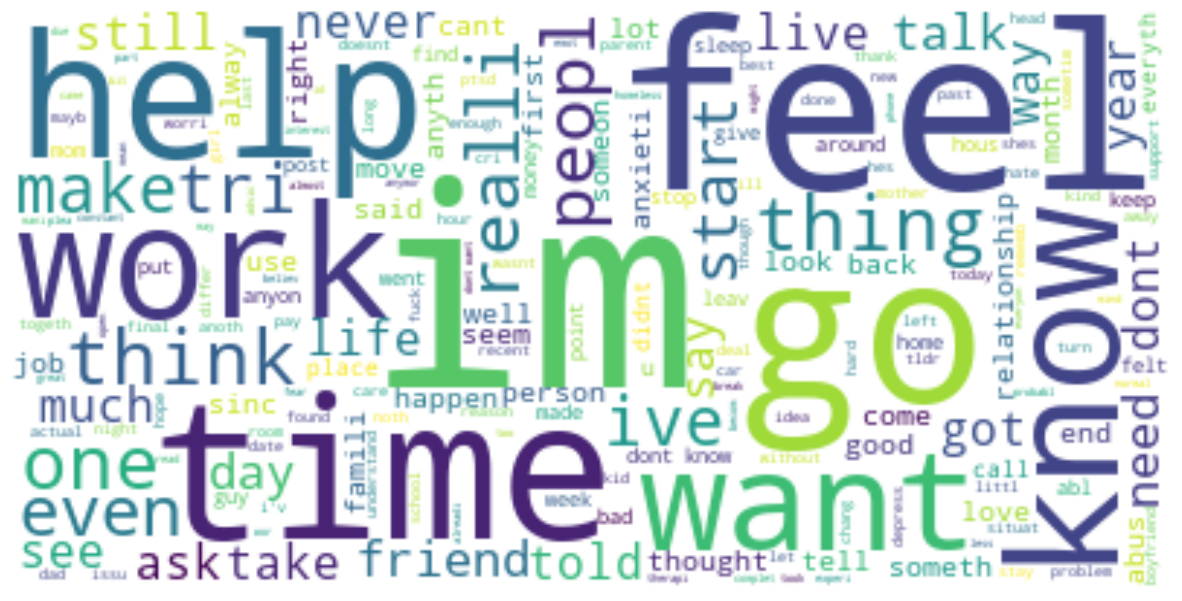

In [12]:
text = " ".join(i for i in df.text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, 
                      background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

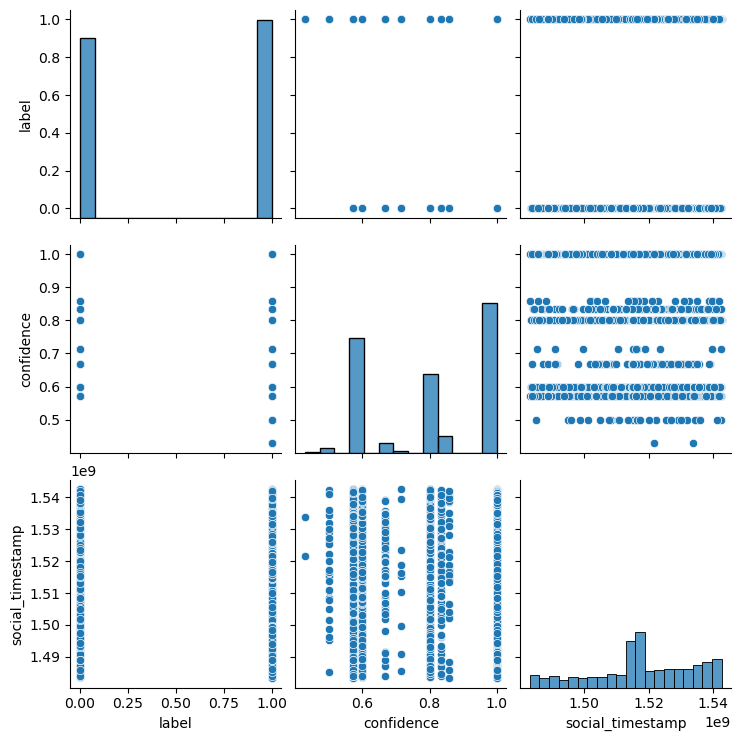

In [13]:
sns.pairplot(df)

In [14]:
df["new_label"] = df["label"].map({0: "No Stress", 1: "Stress"})
df = df[["text", "new_label"]]
print(df.head())

                                                text  new_label
0  said felt way sugget go rest trigger ahead you...     Stress
1  hey rassist sure right place post goe  im curr...  No Stress
2  mom hit newspap shock would know dont like pla...     Stress
3  met new boyfriend amaz kind sweet good student...     Stress
4  octob domest violenc awar month domest violenc...     Stress


**Split Data in Training Set and Test Set**

In [15]:
x = np.array(df["text"])
y = np.array(df["new_label"])
cv = CountVectorizer()
X = cv.fit_transform(x)
xtrain, xtest, ytrain, ytest = train_test_split(X, y, 
                                                test_size=0.33, 
                                                random_state=42)

**Building Models**

**Model 1**

**Bernoulli Naive Bayes**

In [16]:
from sklearn.naive_bayes import BernoulliNB
model_1 = BernoulliNB()
model_1.fit(xtrain,ytrain)

BernoulliNB()

In [17]:
ypred = model_1.predict(xtest)

In [18]:
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

   No Stress       0.79      0.64      0.70       444
      Stress       0.72      0.85      0.78       493

    accuracy                           0.75       937
   macro avg       0.75      0.74      0.74       937
weighted avg       0.75      0.75      0.74       937



**Model 2**

**Multinomial Naive Bayes**

In [19]:
model_2 = MultinomialNB()
model_2.fit(xtrain,ytrain)
print(classification_report(ytest,model_2.predict(xtest)))

              precision    recall  f1-score   support

   No Stress       0.81      0.61      0.69       444
      Stress       0.71      0.87      0.78       493

    accuracy                           0.74       937
   macro avg       0.76      0.74      0.74       937
weighted avg       0.76      0.74      0.74       937



In [20]:
ytrain= LabelEncoder().fit_transform(ytrain) 
ytest=  LabelEncoder().fit_transform(ytest)

**Model 3**

**XGBoost**

In [21]:
model_3 = XGBClassifier()
model_3.fit(xtrain,ytrain)
print(classification_report(ytest,model_3.predict(xtest)))

              precision    recall  f1-score   support

           0       0.72      0.70      0.71       444
           1       0.73      0.76      0.75       493

    accuracy                           0.73       937
   macro avg       0.73      0.73      0.73       937
weighted avg       0.73      0.73      0.73       937



**Model 4**

**Random Forest**

In [22]:
from sklearn.ensemble import RandomForestClassifier
model_4 = RandomForestClassifier(n_estimators=10, criterion='entropy')
model_4.fit(xtrain,ytrain)

RandomForestClassifier(criterion='entropy', n_estimators=10)

In [23]:
ypred = model_4.predict(xtest)

In [24]:
print(classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       0.63      0.66      0.65       444
           1       0.68      0.65      0.67       493

    accuracy                           0.66       937
   macro avg       0.66      0.66      0.66       937
weighted avg       0.66      0.66      0.66       937



**Model Evaluation**

In [25]:
user = input("Text: ")
df = cv.transform([user]).toarray()
output = model_1.predict(df)
print(output)

StdinNotImplementedError: raw_input was called, but this frontend does not support input requests.

In [ ]:
user = input("Text: ")
df = cv.transform([user]).toarray()
output = model_2.predict(df)
print(output)

**Conclusion**

*Bernoulli Naive Bayes perform best with accuracy of 75% overall among four models.*

**Thank you!**

**If anyone want any feedback ,please free to leave feedback.**